In [126]:
import numpy as np
import collections
import pandas as pd
# for cleaning
import regex as re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.decomposition import PCA
# for tokenizing
from nltk.tokenize import word_tokenize
# vectorize tf-idf
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
# for plots and visuals
import matplotlib.pyplot as plt
import seaborn as sns
import time
# reading file form data directory
import os
# for clustering
import scipy.sparse as sparse
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [79]:
# get names of all the files to be clustered
files = os.listdir('/mnt/c/_programming/medius-intern-challenge/ClusterDocs/data')
# ignore the .DS_STORE file
files.remove(files[0])
# store the contents into a list
docsList = []
path = '/mnt/c/_programming/medius-intern-challenge/ClusterDocs/data/'
for file in files:
    p = path+file
    # to handle different encodings
    f = open(p, encoding="ascii", errors="surrogateescape")
    contents = f.read()
    docsList.append(contents)

In [80]:
# parse emails into sender, receiver and body key-value pairs
def parseRawMessage(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'path']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email
def parseEmails(messages):
    emails = [parseRawMessage(message) for message in messages]
    mapp= {'body':[], 'to':[],'_from':[]}
    for email in emails:
        mapp['body'].append(email['body'])
        mapp['to'].append(email['path'])
        mapp['_from'].append(email['from'])
    return mapp

In [81]:
emailDf = pd.DataFrame(parseEmails(docsList))

In [82]:
# removing empty columns if any
emailDf.drop(emailDf.query(
    "body == '' | to == '' | _from == ''"
).index, inplace=True)

In [92]:
# process the body data by removing all punctuations and stop words, then lemmatizing
def cleanText(docsList):
    cleanDocs = []
    # regex patterns for letters, digits, unedrscores
    p1 = re.compile(r'^\W+|\W+$')
    # pattern for newline, tabs, spaces
    p2 = re.compile(r'\s')
    # pattern for punctuations
    p3 = re.compile(r'[^a-zA-Z0-9]')
    lemma = WordNetLemmatizer()
    
    for doc in docsList:
        newToken = ""
        for word in doc.split():
            if (not p1.match(word)) and (not p2.match(word)) and (not p3.match(word)) and (word not in stopwords.words('english')+['the']):
                newToken = newToken + " " + word.lower()
        newToken = lemma.lemmatize(newToken)
        cleanDocs.append(newToken)
    return cleanDocs

In [93]:
newBody = cleanText(emailDf['body'])
emailDf['body'] = newBody

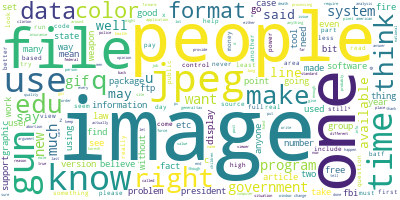

In [94]:
# Visualising the common words in the data
long_string = ' '.join(newBody)
# Create a WordCloud object
#wordcloud = WordCloud(collocations=False,background_color="white", max_words=1000, contour_width=3, contour_color='red')
wordcloud=WordCloud(collocations=False,background_color="white")
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

<BarContainer object of 20 artists>

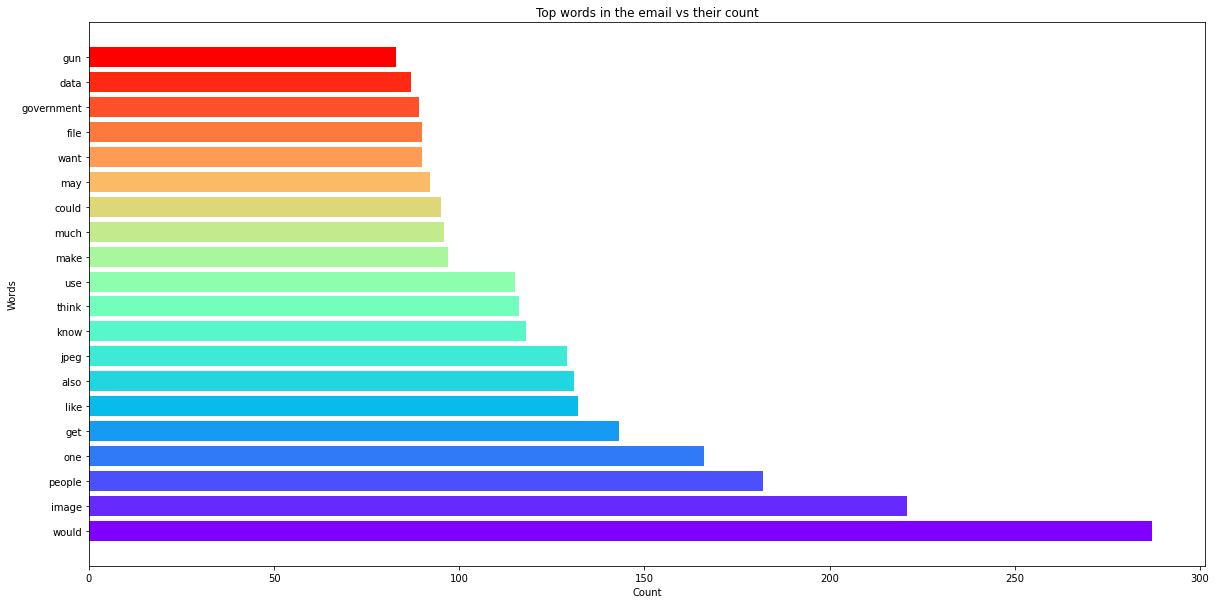

In [95]:
filtered_words = [word for word in long_string.split() if word not in stopwords.words('english')]
counted_words = collections.Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(20):
    words.append(letter)
    counts.append(count)

colors = plt.cm.rainbow(np.linspace(0, 1, 20))
plt.rcParams['figure.figsize'] = 20, 10

plt.title('Top words in the email vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

In [96]:
data = emailDf['body']

tf_idf_vectorizor = TfidfVectorizer(max_features = 5000)
tf_idf = tf_idf_vectorizor.fit_transform(data)
#tf_idf_norm = normalize(tf_idf)
#tf_idf_array = tf_idf_norm.toarray()
#pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

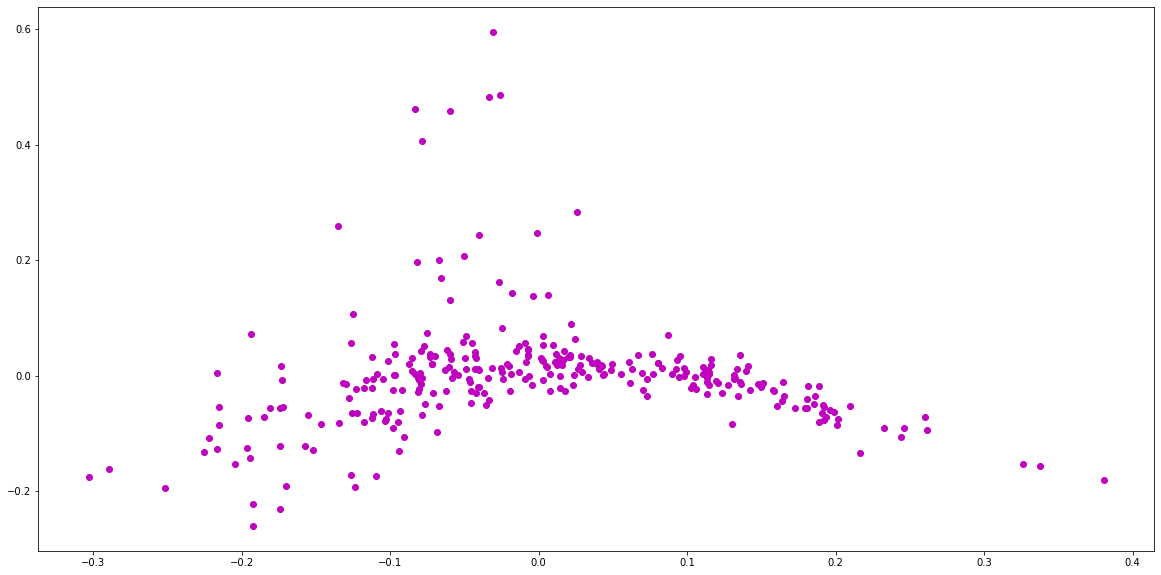

In [97]:
X_dense = tf_idf.todense()
coords = PCA(n_components=2).fit_transform(X_dense)
plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.show()

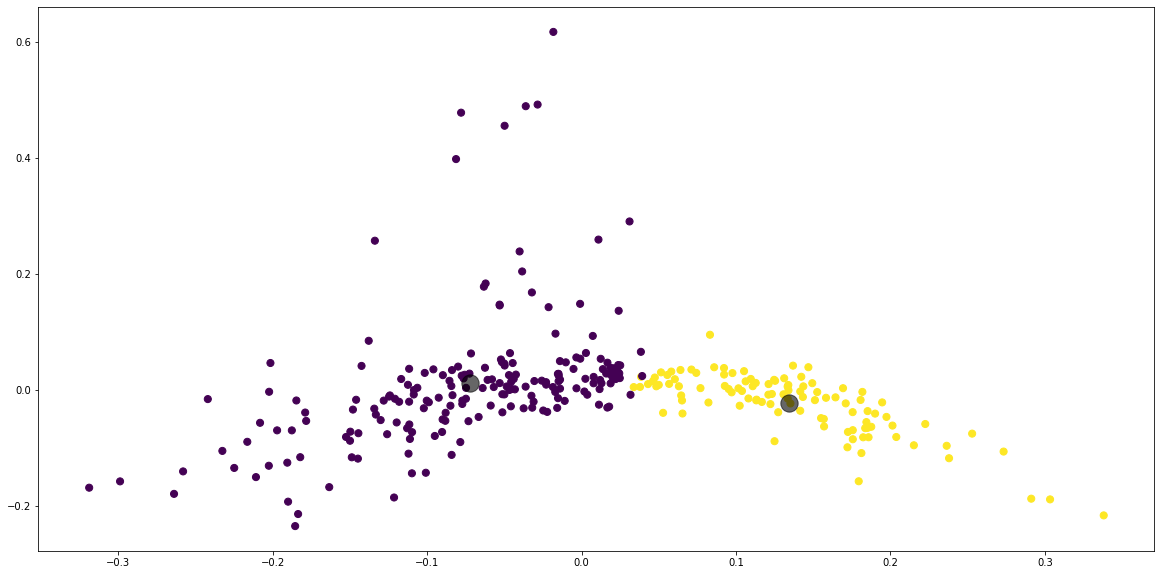

In [160]:
sklearn_pca = PCA(n_components = 10)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
test_e = KMeans(n_clusters=2, max_iter=600, random_state=0)
fitted = test_e.fit(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50)

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);


In [158]:
words = tf_idf_vectorizor.get_feature_names()
k = KMeans(n_clusters = 4, n_init = 17, n_jobs = -1, tol = 0.01, max_iter = 200).fit(tf_idf)
#fit the data 
#k.fit(tf_idf)
#this loop transforms the numbers back into words
common_words = k.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : the, people, would, gun, government, one, it, fbi, think, batf
1 : image, graphics, would, files, format, thanks, know, anyone, program, color


In [159]:
labelCounts = {0:0, 1:0}
for i in k.labels_:
    labelCounts[i] = labelCounts[i]+1
print(labelCounts)

{0: 183, 1: 117}


In [112]:
wcss=[]
for i in range (1, 10):
    k = KMeans(n_clusters = i, n_init = 17, n_jobs = -1, tol = 0.01, max_iter = 200)
    k.fit(tf_idf)
    wcss.append(k.inertia_)


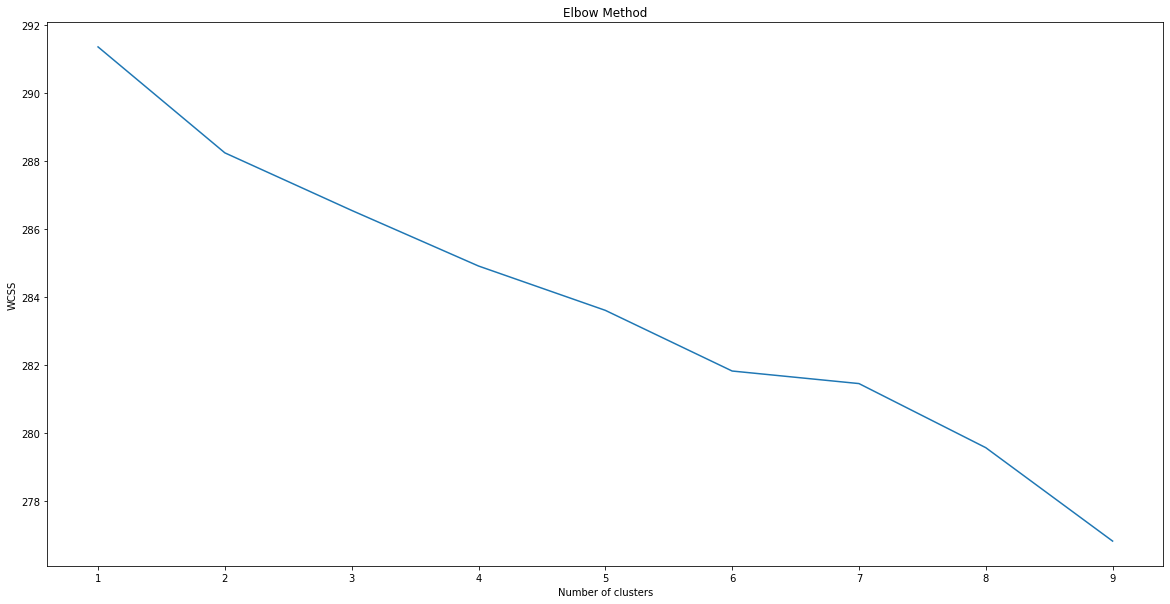

In [113]:
plt.plot(range(1, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()